In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 83.2537
0 -> 5 -> 3 -> 31 -> 42 -> 21 -> 13 -> 7 -> 18 -> 44 -> 36 -> 2 -> 27 -> 11 -> 47 -> 30 -> 10 -> 25 -> 46 -> 19 -> 6 -> 14 -> 39 -> 26 -> 35 -> 33 -> 49 -> 8 -> 22 -> 9 -> 24 -> 15 -> 29 -> 48 -> 17 -> 34 -> 32 -> 4 -> 43 -> 45 -> 23 -> 20 -> 12 -> 41 -> 40 -> 28 -> 38 -> 1 -> 37 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.27it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.72it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.75it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:31<00:00,  4.74it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:57<?, ?it/s]

Epoch   0, Train Regret: 329.3519%, Val Regret: 337.8251%


Epoch    0, Loss:  27.1839:   5%|██▊                                                    | 1/20 [01:53<18:39, 58.92s/it]

Epoch   1, Train Regret:  46.1844%, Val Regret:  47.4684%


Epoch    1, Loss:  24.6667:  10%|█████▌                                                 | 2/20 [02:47<17:05, 56.99s/it]

Epoch   2, Train Regret:  43.2151%, Val Regret:  43.8271%


Epoch    2, Loss:  10.4194:  15%|████████▎                                              | 3/20 [03:43<15:48, 55.81s/it]

Epoch   3, Train Regret:  42.1781%, Val Regret:  43.0032%


Epoch    3, Loss:  11.7285:  20%|███████████                                            | 4/20 [04:39<14:50, 55.65s/it]

Epoch   4, Train Regret:  40.6724%, Val Regret:  41.8218%


Epoch    4, Loss:  12.0927:  25%|█████████████▊                                         | 5/20 [05:34<13:56, 55.75s/it]

Epoch   5, Train Regret:  38.5003%, Val Regret:  39.4238%


Epoch    5, Loss:   9.6509:  30%|████████████████▌                                      | 6/20 [06:29<12:56, 55.49s/it]

Epoch   6, Train Regret:  35.9708%, Val Regret:  37.3799%


Epoch    6, Loss:   8.6855:  35%|███████████████████▎                                   | 7/20 [07:23<11:58, 55.28s/it]

Epoch   7, Train Regret:  33.8930%, Val Regret:  35.1133%


Epoch    7, Loss:   7.2262:  40%|██████████████████████                                 | 8/20 [08:19<11:02, 55.18s/it]

Epoch   8, Train Regret:  31.8780%, Val Regret:  33.2835%


Epoch    8, Loss:  10.4598:  45%|████████████████████████▊                              | 9/20 [09:14<10:06, 55.17s/it]

Epoch   9, Train Regret:  30.8282%, Val Regret:  31.8872%


Epoch    9, Loss:   7.9238:  50%|███████████████████████████                           | 10/20 [10:08<09:12, 55.23s/it]

Epoch  10, Train Regret:  29.9372%, Val Regret:  31.2683%


Epoch   10, Loss:  14.3332:  55%|█████████████████████████████▋                        | 11/20 [11:01<08:13, 54.85s/it]

Epoch  11, Train Regret:  29.4907%, Val Regret:  30.7722%


Epoch   11, Loss:   4.5611:  60%|████████████████████████████████▍                     | 12/20 [11:55<07:15, 54.38s/it]

Epoch  12, Train Regret:  29.3633%, Val Regret:  30.5883%


Epoch   12, Loss:   6.3709:  65%|███████████████████████████████████                   | 13/20 [12:49<06:19, 54.26s/it]

Epoch  13, Train Regret:  28.8848%, Val Regret:  30.1597%


Epoch   13, Loss:   7.4022:  70%|█████████████████████████████████████▊                | 14/20 [13:42<05:23, 53.96s/it]

Epoch  14, Train Regret:  28.8599%, Val Regret:  29.7811%


Epoch   14, Loss:  10.2233:  75%|████████████████████████████████████████▌             | 15/20 [14:36<04:28, 53.70s/it]

Epoch  15, Train Regret:  28.6626%, Val Regret:  30.1044%


Epoch   15, Loss:  16.6805:  80%|███████████████████████████████████████████▏          | 16/20 [15:29<03:35, 53.75s/it]

Epoch  16, Train Regret:  28.7899%, Val Regret:  29.9768%


Epoch   16, Loss:   8.3793:  85%|█████████████████████████████████████████████▉        | 17/20 [16:23<02:53, 57.83s/it]


Epoch  17, Train Regret:  28.9071%, Val Regret:  29.8066%

Early Stop!

Evaluation:
Test Regret: 29.2286%
Training Elapsed Time: 2.54 Sec


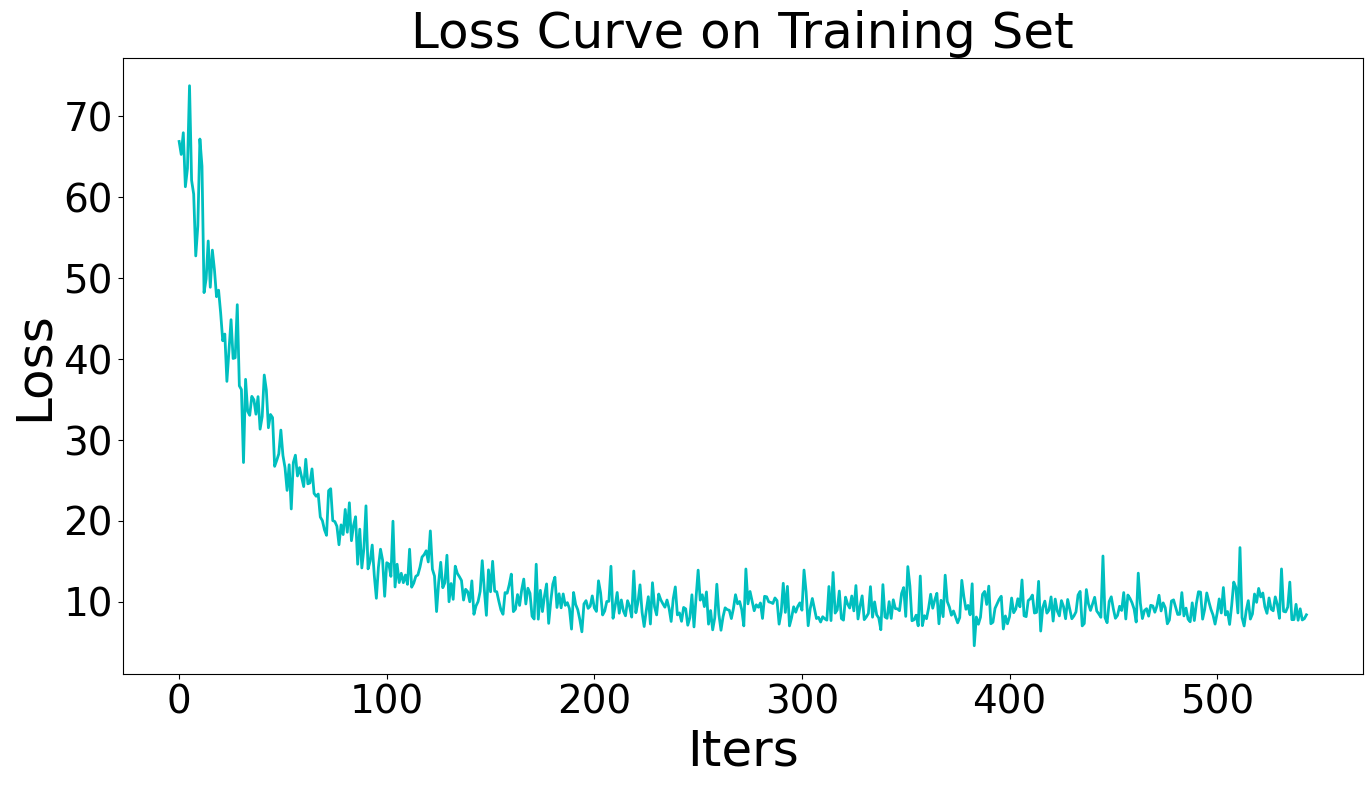

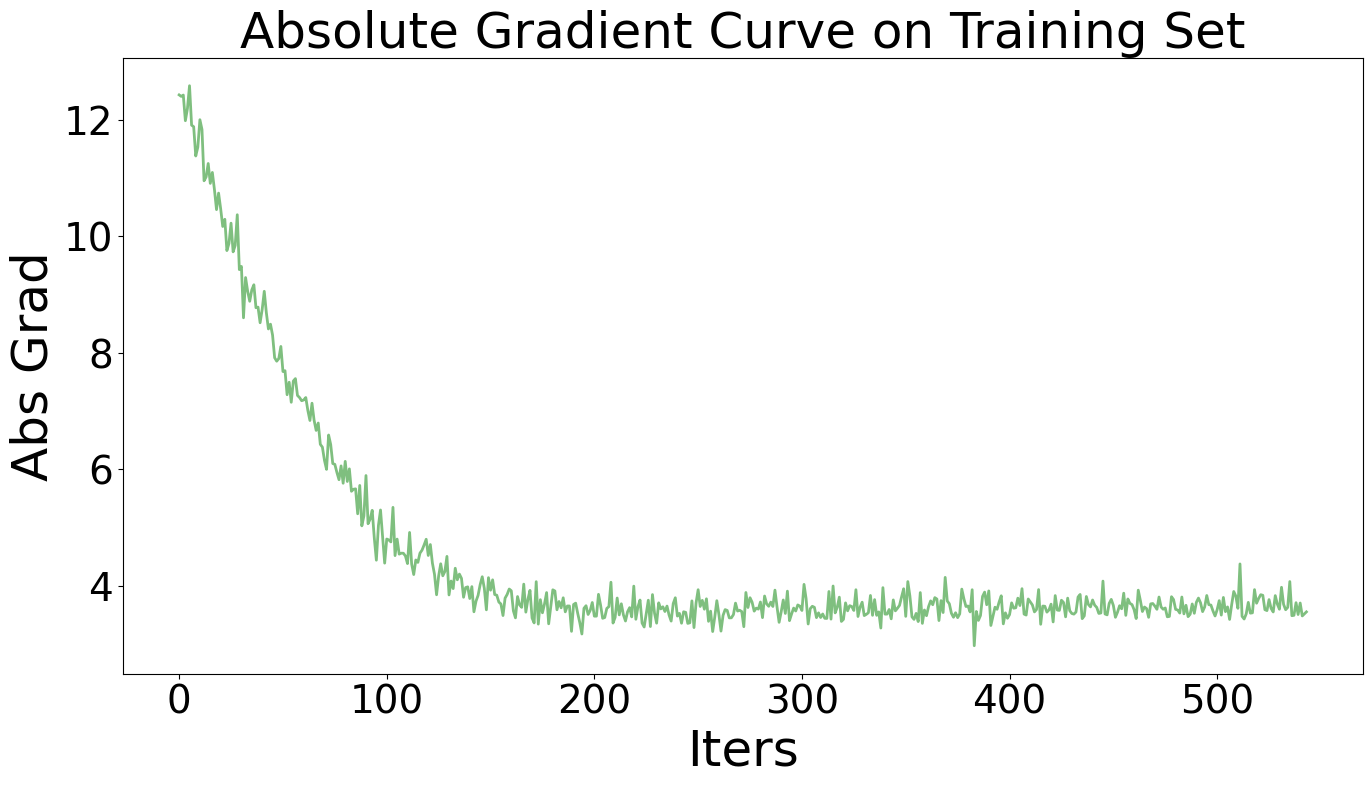

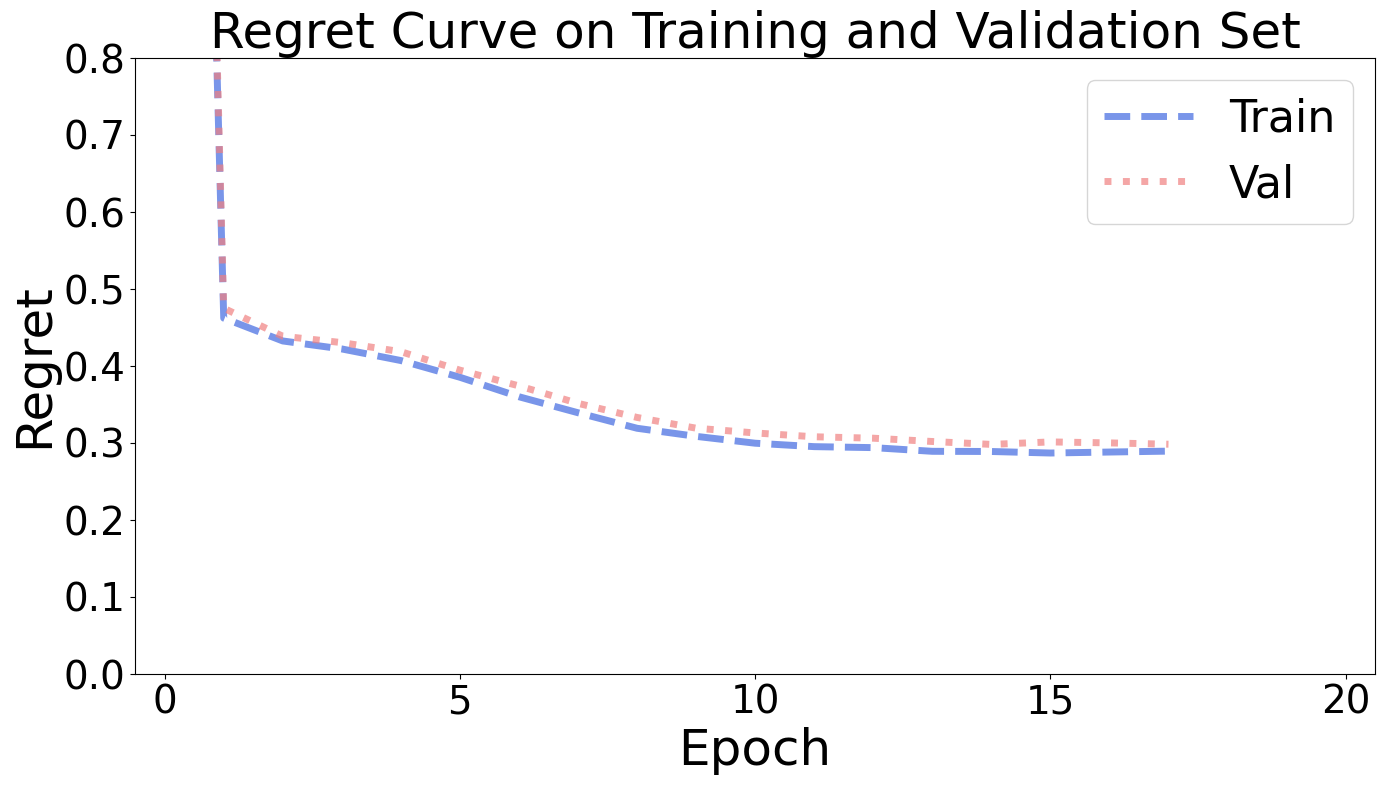

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:51<?, ?it/s]

Epoch   0, Train Regret: 319.7730%, Val Regret: 329.2941%


Epoch    0, Loss:  -0.9986:   5%|██▋                                                   | 1/20 [02:45<34:20, 108.43s/it]

Epoch   1, Train Regret:  24.6385%, Val Regret:  30.3647%


Epoch    1, Loss:  -0.9994:  10%|█████▌                                                 | 2/20 [04:19<29:59, 99.98s/it]

Epoch   2, Train Regret:  16.2672%, Val Regret:  20.7263%


Epoch    2, Loss:  -0.9996:  15%|████████▎                                              | 3/20 [05:53<27:27, 96.92s/it]

Epoch   3, Train Regret:  13.7630%, Val Regret:  18.8476%


Epoch    3, Loss:  -0.9997:  20%|███████████                                            | 4/20 [07:24<25:24, 95.26s/it]

Epoch   4, Train Regret:  12.4978%, Val Regret:  17.8991%


Epoch    4, Loss:  -0.9997:  25%|█████████████▊                                         | 5/20 [09:00<23:33, 94.23s/it]

Epoch   5, Train Regret:  12.0634%, Val Regret:  17.3406%


Epoch    5, Loss:  -0.9998:  30%|████████████████▌                                      | 6/20 [10:32<22:01, 94.40s/it]

Epoch   6, Train Regret:  11.3554%, Val Regret:  17.4593%


Epoch    6, Loss:  -0.9998:  35%|███████████████████▎                                   | 7/20 [12:04<20:17, 93.63s/it]

Epoch   7, Train Regret:  11.2681%, Val Regret:  16.1714%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [13:35<18:34, 92.87s/it]

Epoch   8, Train Regret:  10.8502%, Val Regret:  16.8381%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▊                              | 9/20 [15:08<16:57, 92.53s/it]

Epoch   9, Train Regret:  10.3494%, Val Regret:  16.2909%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [16:41<16:41, 100.14s/it]


Epoch  10, Train Regret:  10.8589%, Val Regret:  17.3081%

Early Stop!

Evaluation:
Test Regret: 16.1930%
Training Elapsed Time: 366.57 Sec


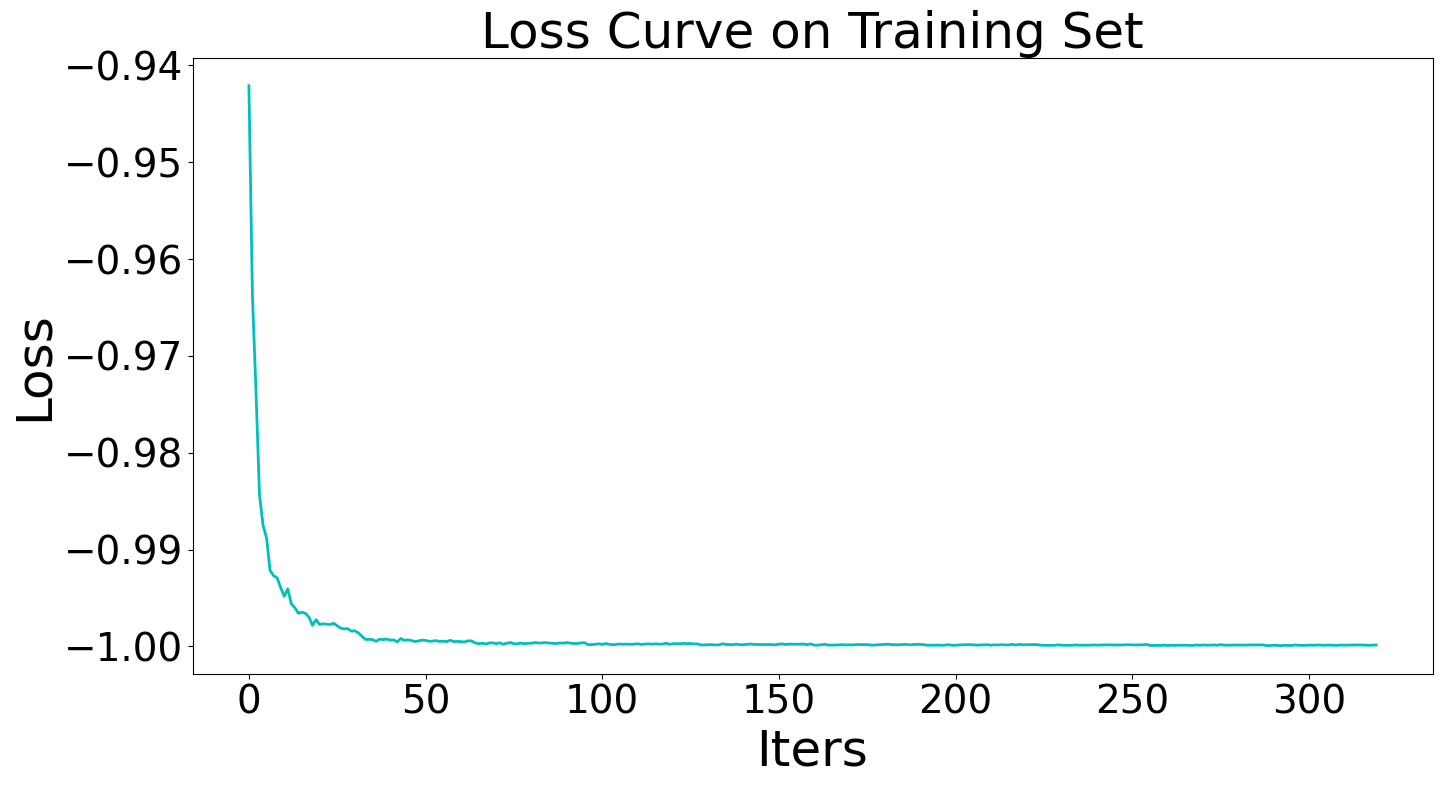

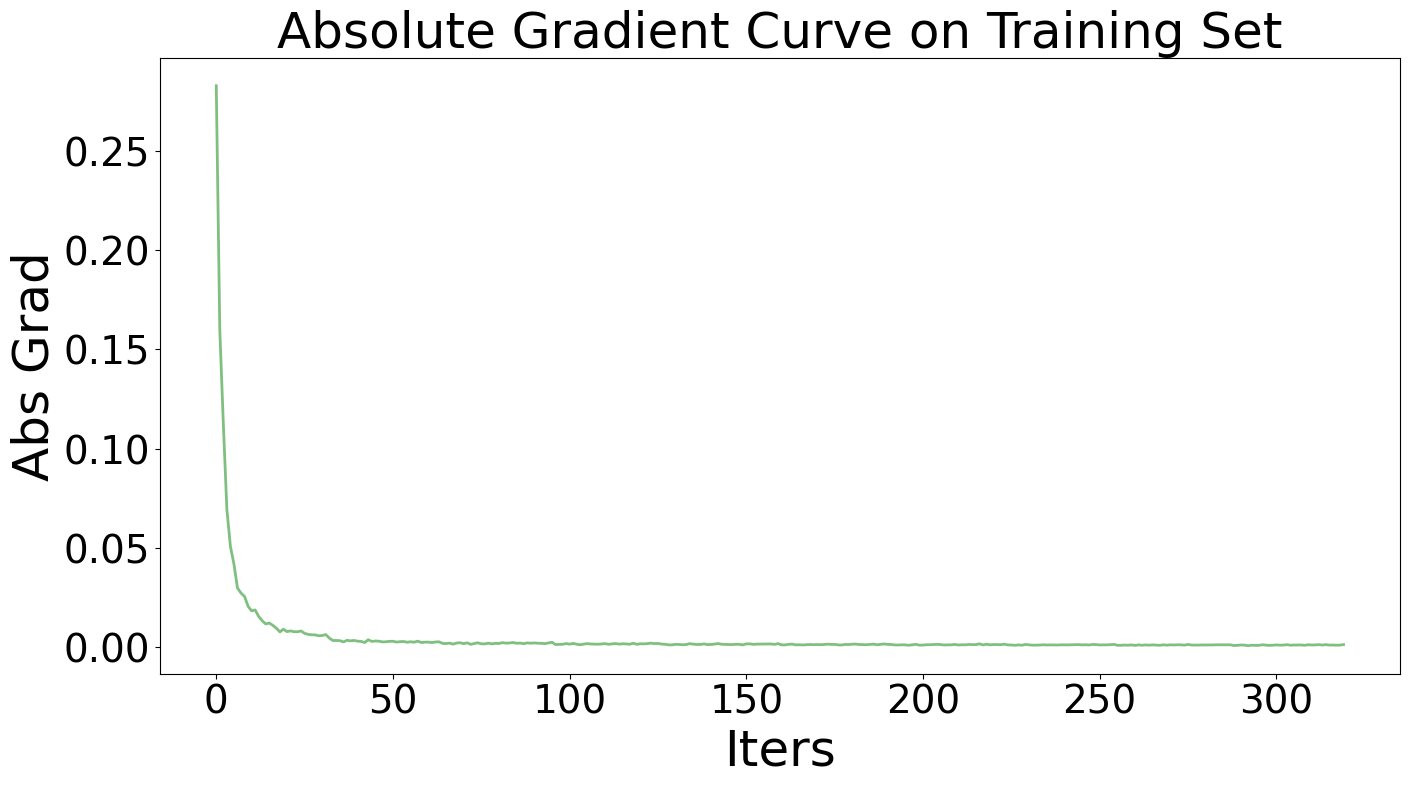

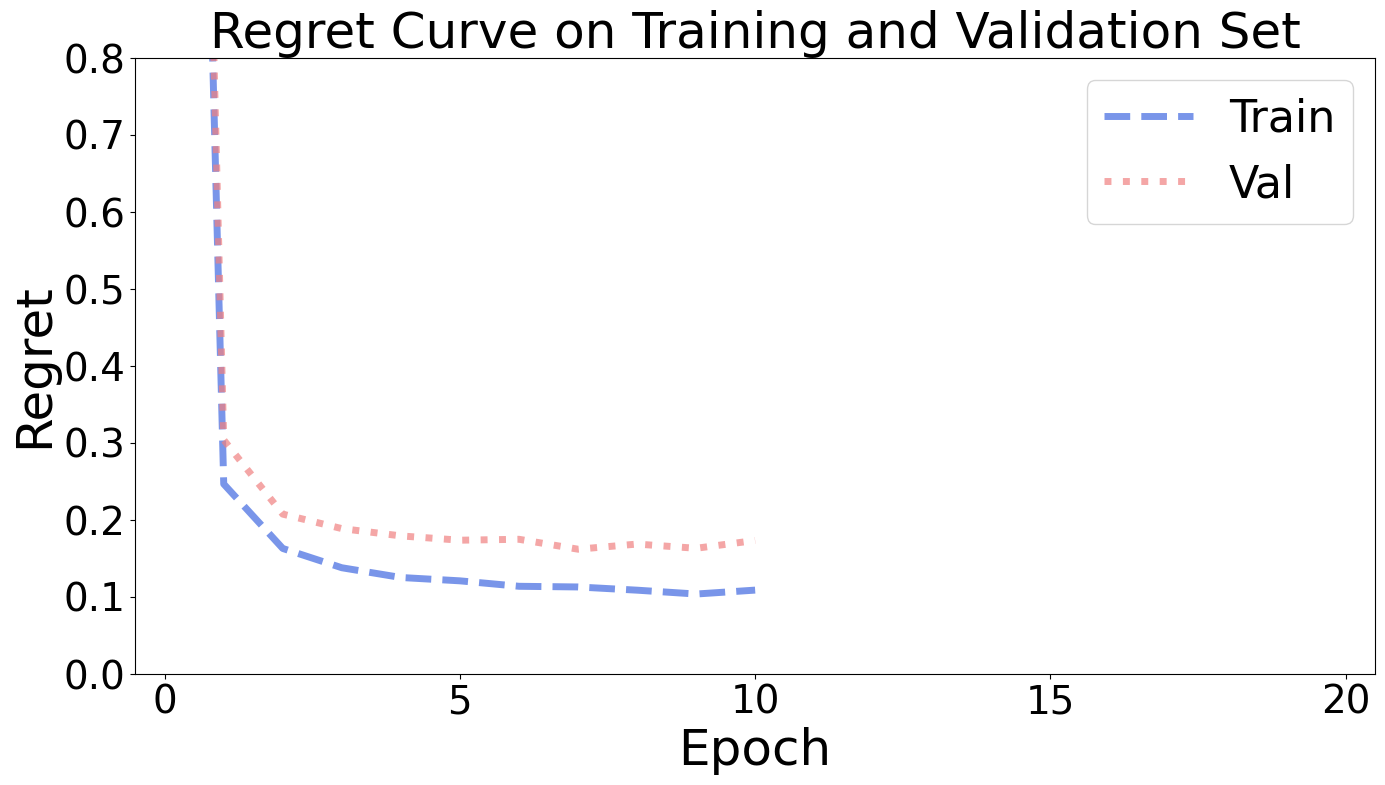

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:53<?, ?it/s]

Epoch   0, Train Regret: 321.2164%, Val Regret: 325.3359%


Epoch    0, Loss:  -0.6373:   5%|██▊                                                    | 1/20 [02:08<20:06, 63.50s/it]

Epoch   1, Train Regret:  27.9165%, Val Regret:  30.7705%


Epoch    1, Loss:  -0.7154:  10%|█████▌                                                 | 2/20 [03:26<21:10, 70.60s/it]

Epoch   2, Train Regret:  21.3456%, Val Regret:  22.0943%


Epoch    2, Loss:  -0.7959:  15%|████████▎                                              | 3/20 [04:42<20:50, 73.57s/it]

Epoch   3, Train Regret:  21.1726%, Val Regret:  23.3646%


Epoch    3, Loss:  -0.8411:  20%|███████████                                            | 4/20 [06:01<20:00, 75.00s/it]

Epoch   4, Train Regret:  21.6398%, Val Regret:  23.0709%


Epoch    4, Loss:  -0.8072:  25%|█████████████▊                                         | 5/20 [07:18<21:56, 87.78s/it]


Epoch   5, Train Regret:  20.8509%, Val Regret:  23.1586%

Early Stop!

Evaluation:
Test Regret: 22.3094%
Training Elapsed Time: 47.20 Sec


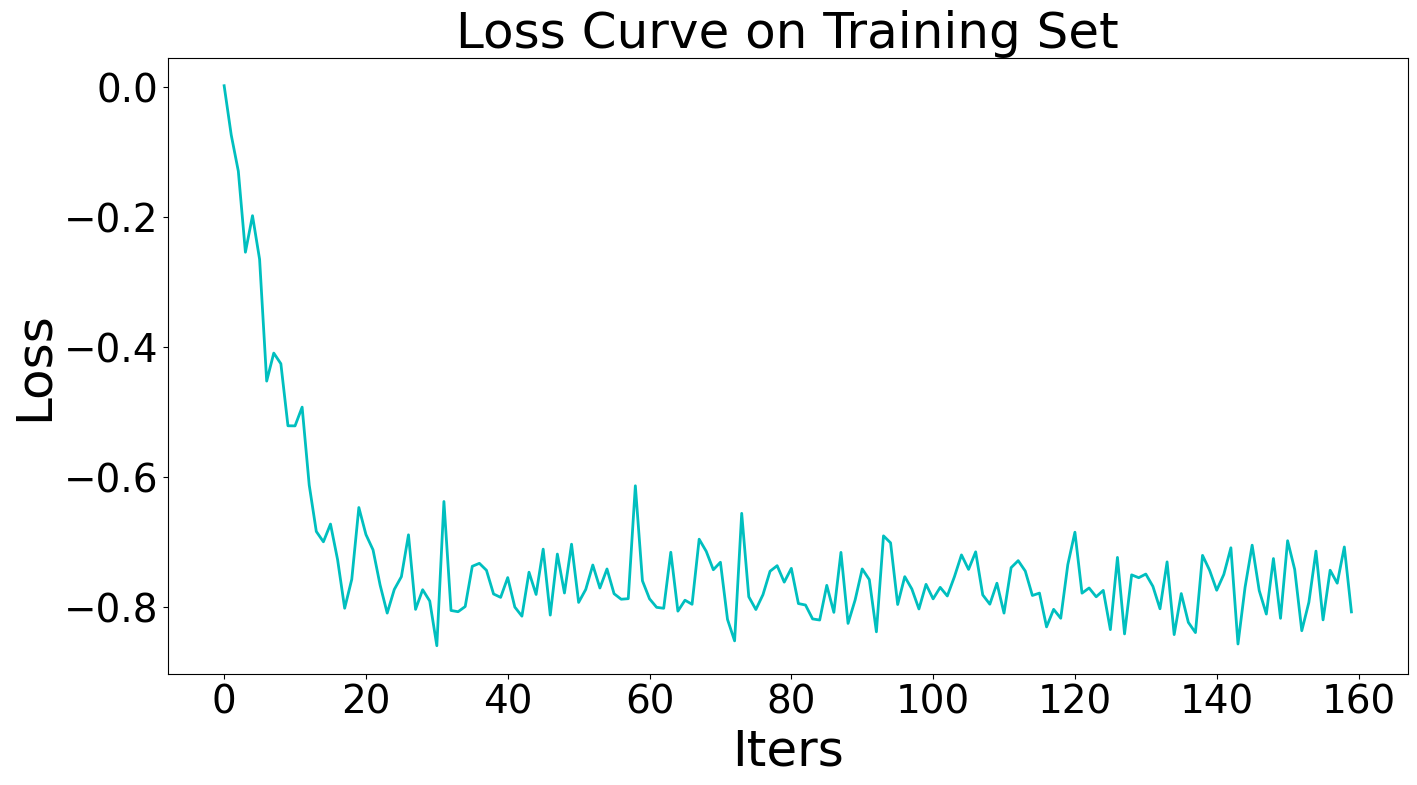

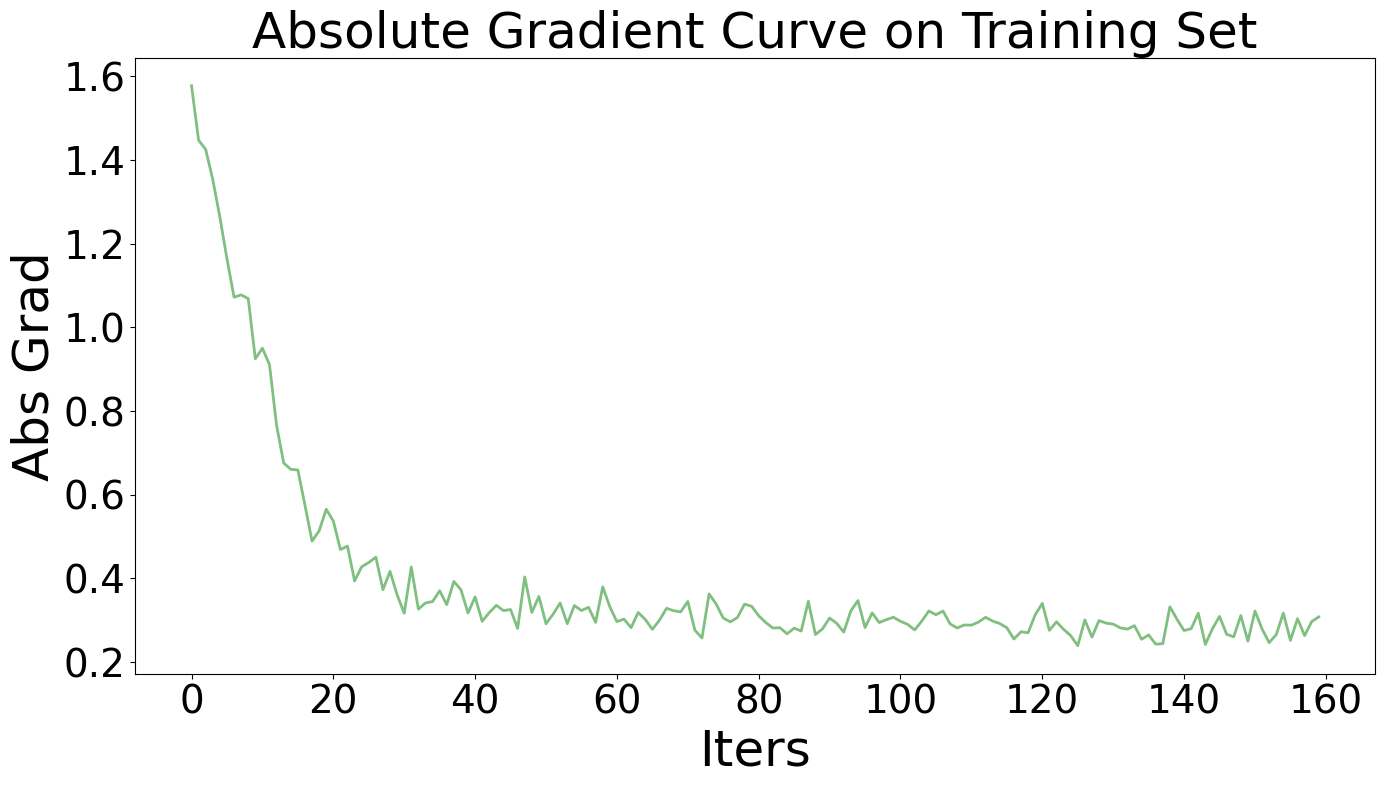

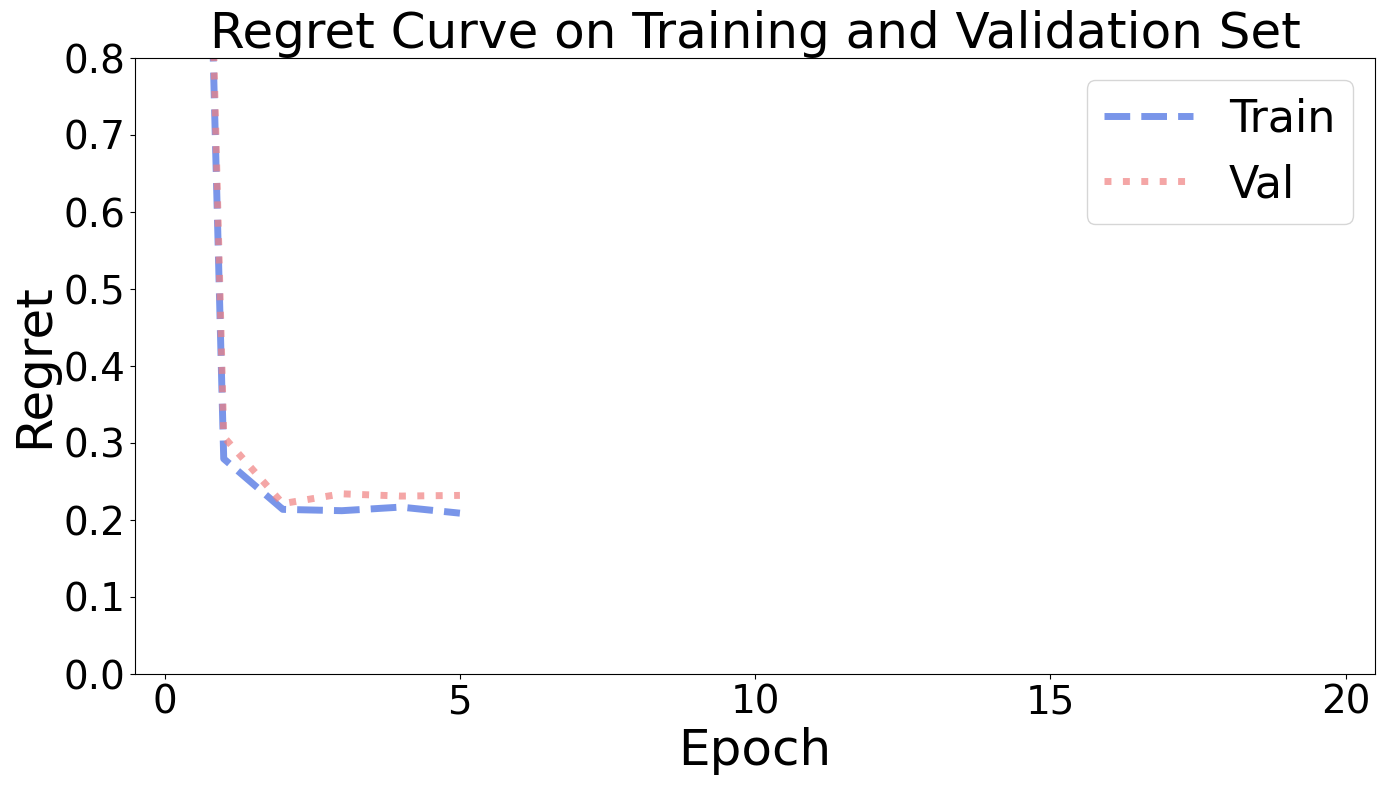

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL

In [24]:
# init model
reg = LinearRegression()

In [25]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [26]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:54<?, ?it/s]

Epoch   0, Train Regret: 308.0348%, Val Regret: 312.3214%


Epoch    0, Loss:  56.5000:   5%|██▊                                                    | 1/20 [02:19<24:39, 77.89s/it]

Epoch   1, Train Regret:  12.0109%, Val Regret:  13.5123%


Epoch    1, Loss:  51.0000:  10%|█████▌                                                 | 2/20 [03:38<24:13, 80.76s/it]

Epoch   2, Train Regret:   8.7732%, Val Regret:   9.5797%


Epoch    2, Loss:  48.5000:  15%|████████▎                                              | 3/20 [05:00<22:56, 80.96s/it]

Epoch   3, Train Regret:   8.2269%, Val Regret:   9.3051%


Epoch    3, Loss:  44.7500:  20%|███████████                                            | 4/20 [06:19<21:28, 80.50s/it]

Epoch   4, Train Regret:   7.7437%, Val Regret:   9.1241%


Epoch    4, Loss:  42.0000:  25%|█████████████▊                                         | 5/20 [07:40<20:07, 80.47s/it]

Epoch   5, Train Regret:   7.5165%, Val Regret:   8.2001%


Epoch    5, Loss:  41.7500:  30%|████████████████▌                                      | 6/20 [09:03<18:51, 80.85s/it]

Epoch   6, Train Regret:   7.1901%, Val Regret:   8.1480%


Epoch    6, Loss:  44.2500:  35%|███████████████████▎                                   | 7/20 [10:25<17:38, 81.42s/it]

Epoch   7, Train Regret:   7.1973%, Val Regret:   8.6428%


Epoch    7, Loss:  36.2500:  40%|██████████████████████                                 | 8/20 [11:46<16:17, 81.46s/it]

Epoch   8, Train Regret:   6.9112%, Val Regret:   8.1703%


Epoch    8, Loss:  40.2500:  45%|████████████████████████▊                              | 9/20 [13:07<14:56, 81.51s/it]

Epoch   9, Train Regret:   6.8066%, Val Regret:   7.8656%


Epoch    9, Loss:  41.7500:  50%|███████████████████████████                           | 10/20 [14:28<13:32, 81.27s/it]

Epoch  10, Train Regret:   6.9464%, Val Regret:   8.0331%


Epoch   10, Loss:  37.7500:  55%|█████████████████████████████▋                        | 11/20 [15:48<12:08, 80.98s/it]

Epoch  11, Train Regret:   6.7905%, Val Regret:   8.3629%


Epoch   11, Loss:  39.2500:  60%|████████████████████████████████▍                     | 12/20 [17:07<11:24, 85.61s/it]


Epoch  12, Train Regret:   6.8941%, Val Regret:   8.3668%

Early Stop!

Evaluation:
Test Regret: 8.0912%
Training Elapsed Time: 255.09 Sec


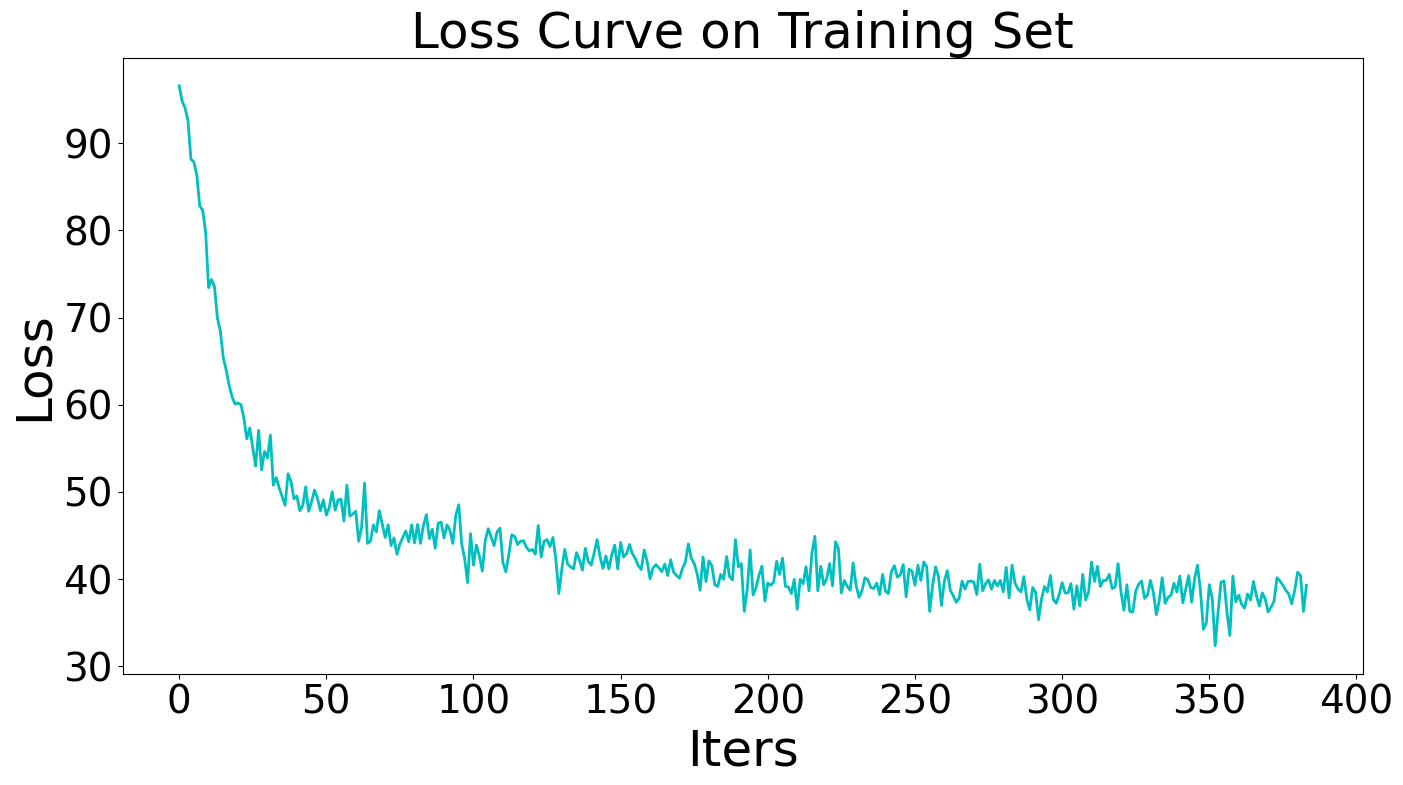

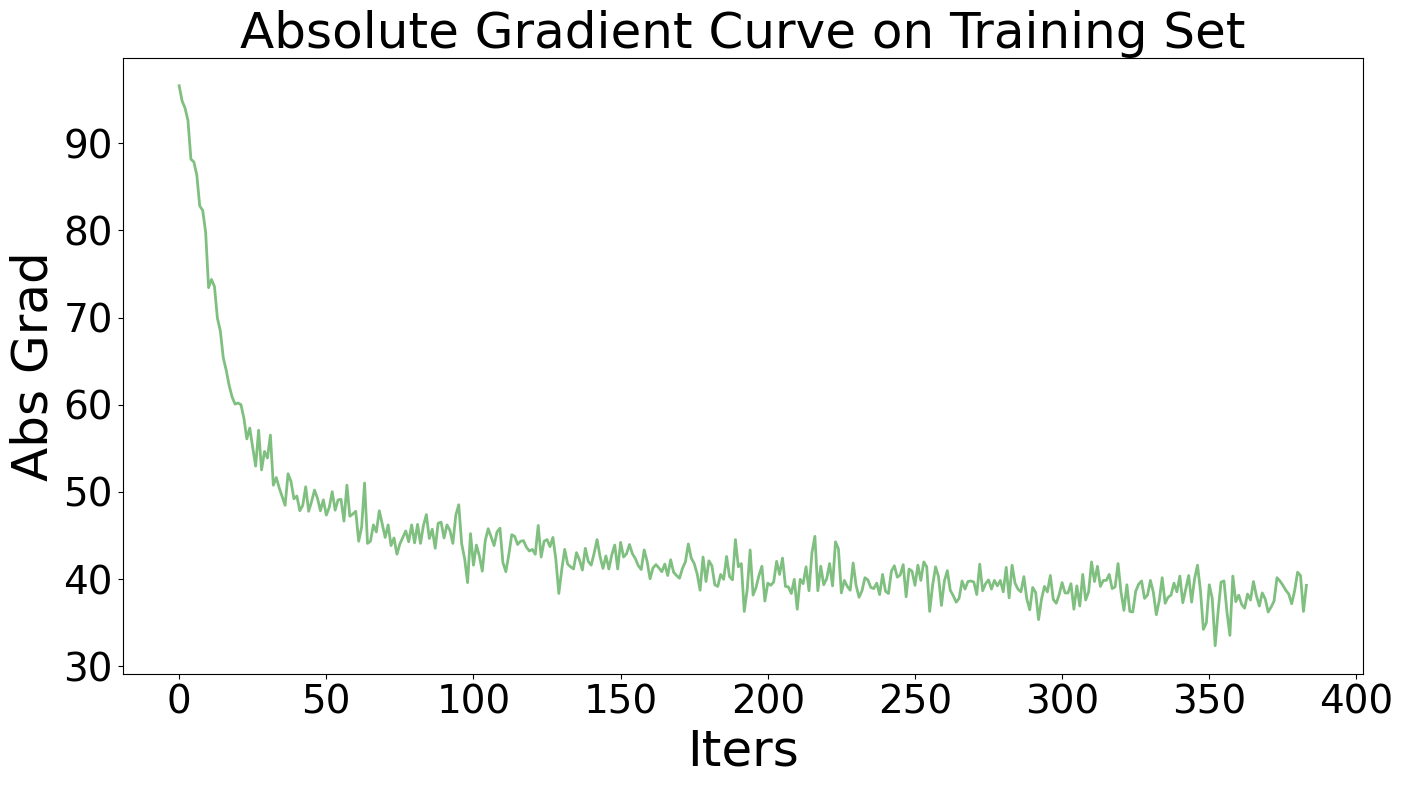

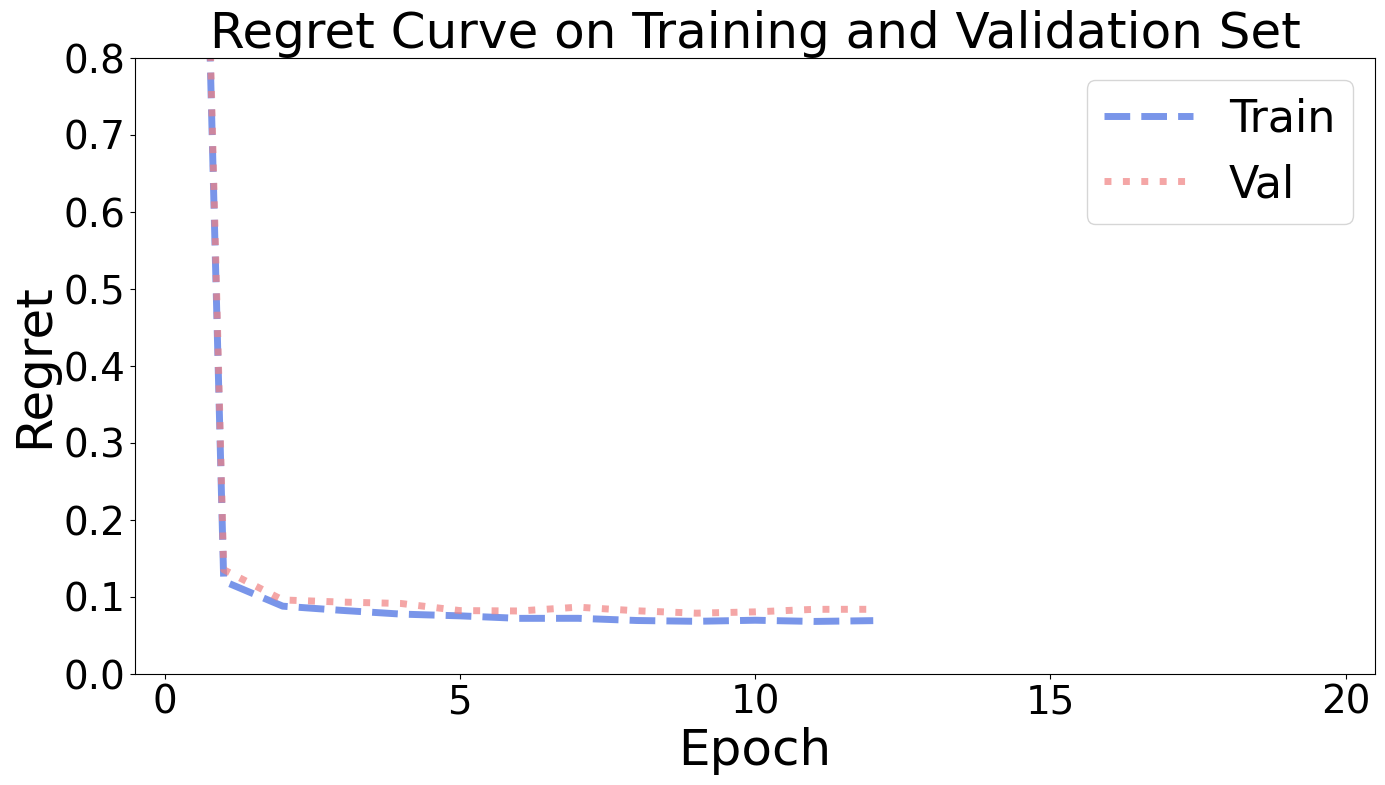

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [30]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:53<?, ?it/s]

Epoch   0, Train Regret: 323.0378%, Val Regret: 327.6085%


Epoch    0, Loss: -126.5537:   5%|██▋                                                   | 1/20 [01:58<20:05, 63.42s/it]

Epoch   1, Train Regret:  22.9285%, Val Regret:  25.5718%


Epoch    1, Loss: -318.2574:  10%|█████▍                                                | 2/20 [03:08<19:45, 65.89s/it]

Epoch   2, Train Regret:  16.3908%, Val Regret:  18.7512%


Epoch    2, Loss: -462.2196:  15%|████████                                              | 3/20 [04:14<18:54, 66.71s/it]

Epoch   3, Train Regret:  15.0969%, Val Regret:  17.4235%


Epoch    3, Loss: -701.2319:  20%|██████████▊                                           | 4/20 [05:21<17:47, 66.71s/it]

Epoch   4, Train Regret:  14.5348%, Val Regret:  16.9046%


Epoch    4, Loss: -863.9677:  25%|█████████████▌                                        | 5/20 [06:26<16:36, 66.47s/it]

Epoch   5, Train Regret:  14.2444%, Val Regret:  16.7467%


Epoch    5, Loss: -1071.6694:  30%|███████████████▉                                     | 6/20 [07:33<15:27, 66.28s/it]

Epoch   6, Train Regret:  13.9116%, Val Regret:  16.7383%


Epoch    6, Loss: -1137.2772:  35%|██████████████████▌                                  | 7/20 [08:38<14:24, 66.48s/it]

Epoch   7, Train Regret:  13.7881%, Val Regret:  16.2411%


Epoch    7, Loss: -1470.8503:  40%|█████████████████████▏                               | 8/20 [09:44<13:14, 66.22s/it]

Epoch   8, Train Regret:  13.6403%, Val Regret:  16.1500%


Epoch    8, Loss: -1676.9517:  45%|███████████████████████▊                             | 9/20 [10:49<12:03, 65.76s/it]

Epoch   9, Train Regret:  13.5285%, Val Regret:  16.0477%


Epoch    9, Loss: -1549.0540:  50%|██████████████████████████                          | 10/20 [11:56<10:57, 65.78s/it]

Epoch  10, Train Regret:  13.3860%, Val Regret:  15.8841%


Epoch   10, Loss: -2208.3142:  55%|████████████████████████████▌                       | 11/20 [13:04<10:01, 66.79s/it]

Epoch  11, Train Regret:  13.4456%, Val Regret:  15.5256%


Epoch   11, Loss: -1764.1595:  60%|███████████████████████████████▏                    | 12/20 [14:14<08:53, 66.71s/it]

Epoch  12, Train Regret:  13.2254%, Val Regret:  15.6320%


Epoch   12, Loss: -2025.3806:  65%|█████████████████████████████████▊                  | 13/20 [15:18<07:48, 67.00s/it]

Epoch  13, Train Regret:  13.2151%, Val Regret:  15.4690%


Epoch   13, Loss: -2551.7031:  70%|████████████████████████████████████▍               | 14/20 [16:23<06:37, 66.23s/it]

Epoch  14, Train Regret:  13.0834%, Val Regret:  15.3050%


Epoch   14, Loss: -2789.7239:  75%|███████████████████████████████████████             | 15/20 [17:32<05:32, 66.57s/it]

Epoch  15, Train Regret:  12.9676%, Val Regret:  15.5137%


Epoch   15, Loss: -3194.6414:  80%|█████████████████████████████████████████▌          | 16/20 [18:38<04:25, 66.45s/it]

Epoch  16, Train Regret:  12.9268%, Val Regret:  15.6036%


Epoch   16, Loss: -2914.4111:  85%|████████████████████████████████████████████▏       | 17/20 [19:44<03:29, 69.68s/it]


Epoch  17, Train Regret:  12.8458%, Val Regret:  15.4001%

Early Stop!

Evaluation:
Test Regret: 15.0514%
Training Elapsed Time: 165.16 Sec


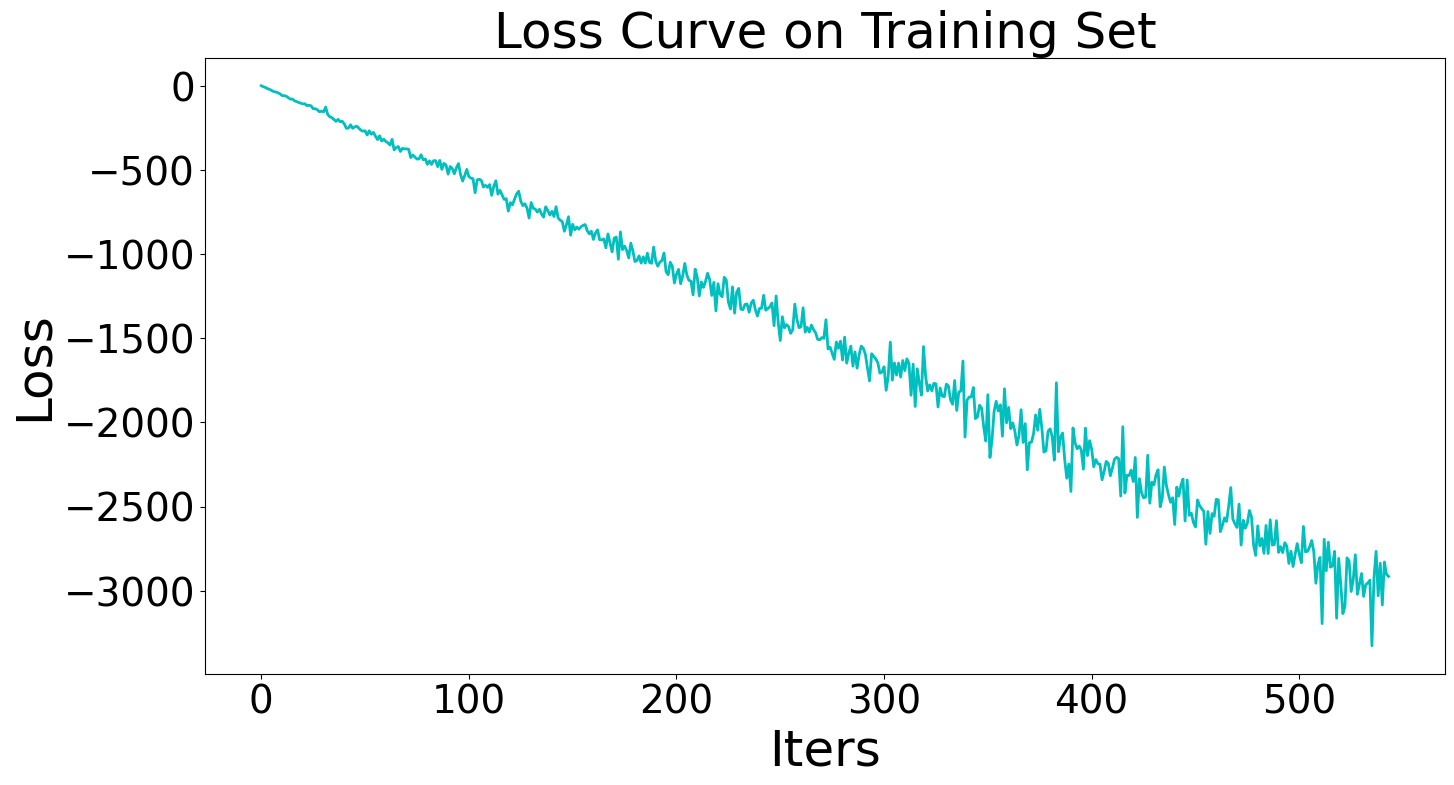

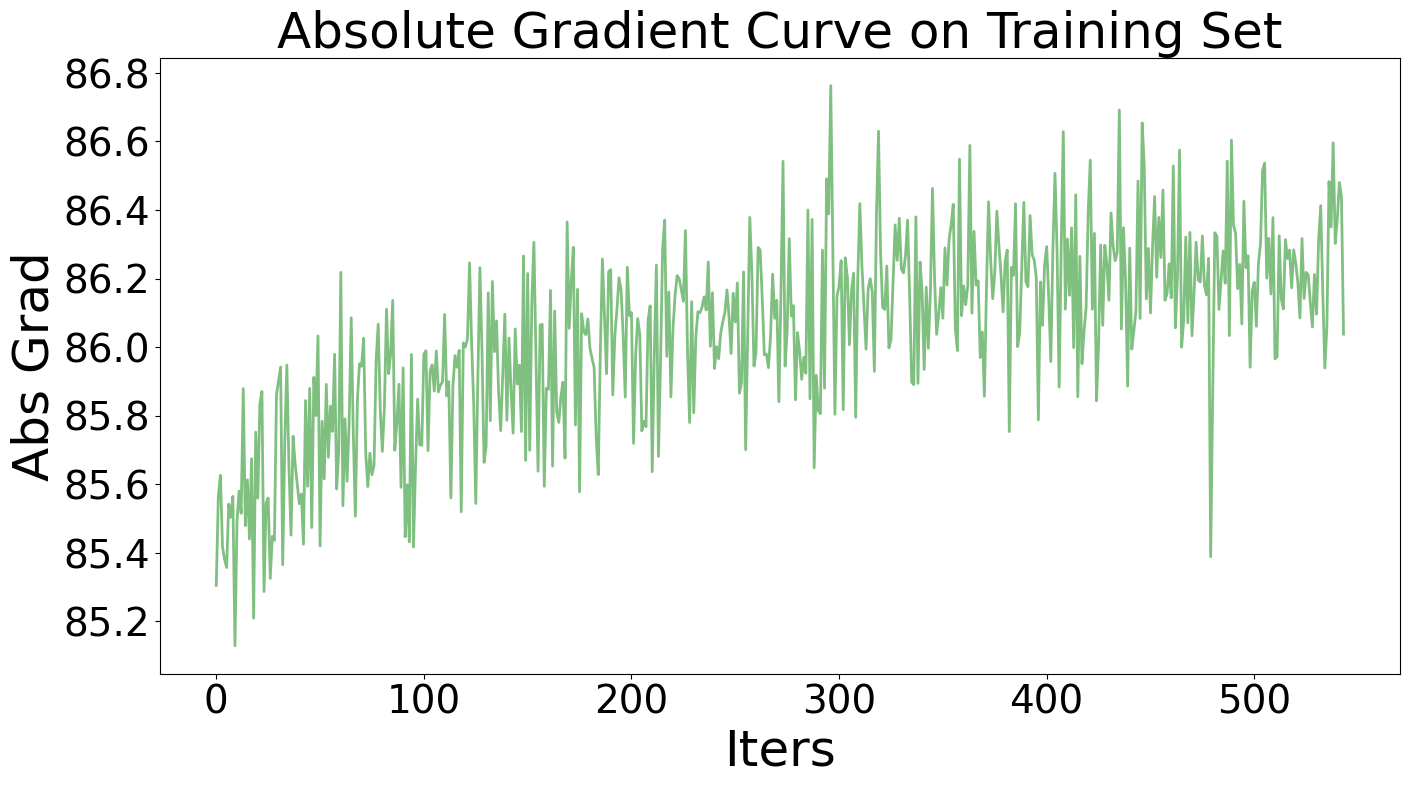

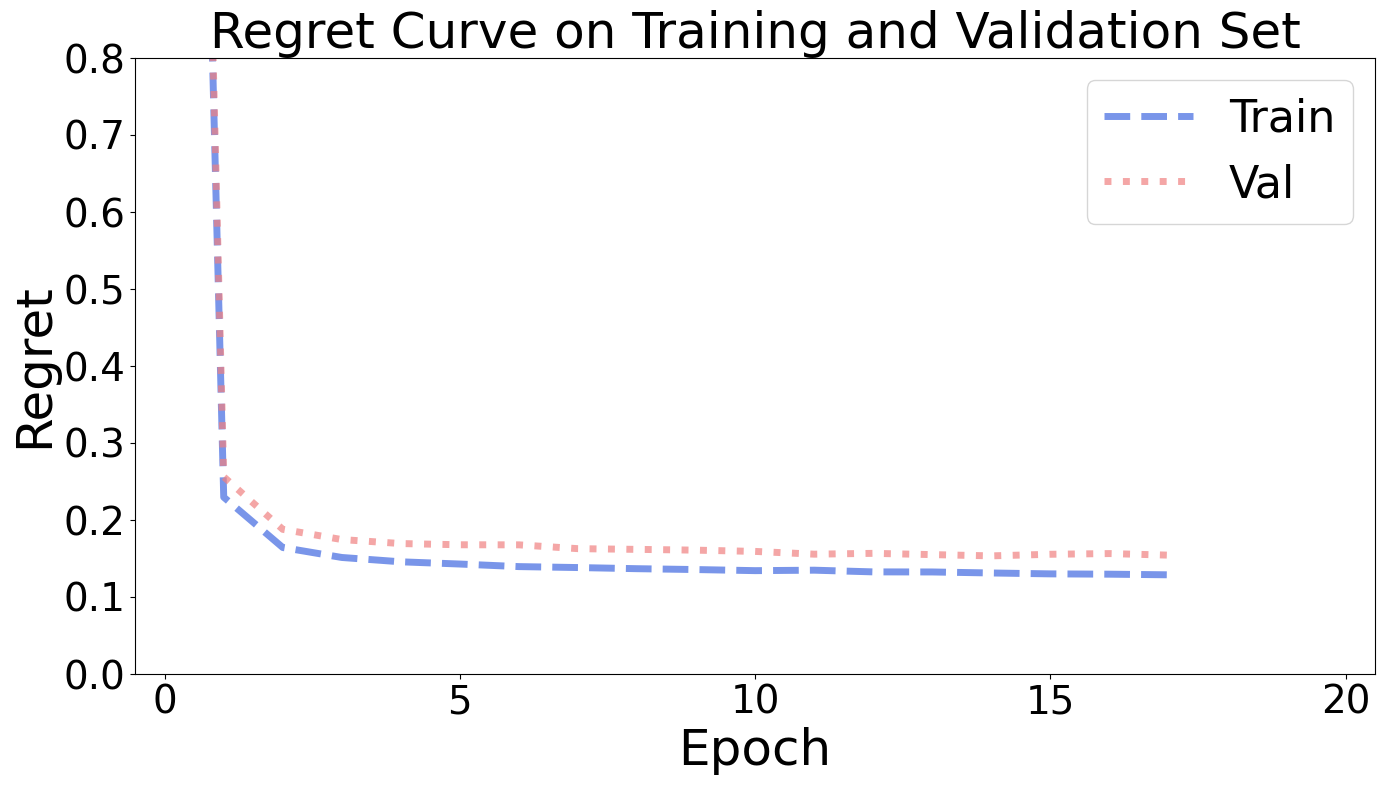

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)